In [1]:
if True: # if for code folding in notebooks. Standard snippet importing everything I might need.
    import numpy  as np
    import numpy.random as npr
    import pandas as pd
    import scipy.sparse as sp
    import cython
    from numba import jit, njit

    import sklearn as skl
    import sklearn.preprocessing
    import sklearn.model_selection
    import sklearn.metrics

    import torch as th
    import torch.nn as nn
    from torch.autograd import Function, Variable as Var
    from torch.nn import functional as F

    import array
    import glob
    import gc
    import os
    import pickle
    import random
    import re
    import sys
    import time
    from tqdm import tqdm

    from plotly.offline import init_notebook_mode, plot, iplot
    from matplotlib import pyplot as plt

    %matplotlib inline
    %load_ext Cython
    np.random.seed(0)
    init_notebook_mode(connected=False)
    plt.style.use("dark_background")

In [2]:
if True:
    from torch.utils import data
    from torch.utils.data import sampler

    import visdom

    from unetelan.data.preprocess import (HRFLoader, DRVLoader, Rotate, RandomCrop, RegularCrop,
                                          RGBConverter, ToNumpy, FeatureWiseStd, ChannelWiseStd,
                                          Standardizer, ListDataset, make_collate)
    from unetelan.models.unet import UNet
    from unetelan.training.config import Config, Metadata
    from unetelan.training.logger import update_trace, video
    from unetelan.training.train import (adjust_lr, binarize, as_float_cpu, accuracy_score, roc_auc_score)

In [3]:
FINAL = '../data/final'


DATASETS = [
    "HRF_GMEAN_GSTD",
    "DRV_GMEAN_GSTD_1",
    "DRV_GMEAN_GSTD_2",
    
    "HRF_GMEAN_GSTD",
    "DRV_GMEAN_GSTD_1",
    "DRV_GMEAN_GSTD_2",
]


# CONFIGS = [
#     Config(bn=True, dp=0., n_layers=3, filters_base=48, patch_border=0, n_classes=1, n_channels=3),
#     Config(bn=True, dp=0., n_layers=3, filters_base=48, patch_border=0, n_classes=1, n_channels=3),
#     Config(bn=True, dp=0., n_layers=3, filters_base=48, patch_border=0, n_classes=1, n_channels=3),
        
#     Config(bn=True, dp=3., n_layers=3, filters_base=48, patch_border=0, n_classes=1, n_channels=3),
#     Config(bn=True, dp=3., n_layers=3, filters_base=48, patch_border=0, n_classes=1, n_channels=3),
#     Config(bn=True, dp=3., n_layers=3, filters_base=48, patch_border=0, n_classes=1, n_channels=3),
# ]


# METAS = [
#     Metadata(k=2, n_rot=3, n_crop=300, crop_sz=128, step_sz=64, img_sz=(3504, 2336)),
#     Metadata(k=2, n_rot=6, n_crop=300, crop_sz=128, step_sz=64, img_sz=(565, 584)),
#     Metadata(k=2, n_rot=6, n_crop=500, crop_sz=64,  step_sz=32, img_sz=(565, 584)),
    
#     Metadata(k=2, n_rot=3, n_crop=300, crop_sz=128, step_sz=64, img_sz=(3504, 2336)),
#     Metadata(k=2, n_rot=6, n_crop=300, crop_sz=128, step_sz=64, img_sz=(565, 584)),
#     Metadata(k=2, n_rot=6, n_crop=500, crop_sz=64,  step_sz=32, img_sz=(565, 584)),
# ]

In [4]:
X_test = Y_test = dset_test = samp_test = collate_fn = None
test = model = bce = adam = vis = None
step = loss_win = epoc_win = f = i = images = masks = None
preds = loss = acc = auc = None

In [8]:
model_f = "../data-ssd/model-0-DRV_GMEAN_GSTD_1.th"
name    = "DRV_GMEAN_GSTD_1/"

cfg   = Config(ID=None, bn=True, dp=0., n_layers=3, filters_base=48, patch_border=0, n_classes=1, n_channels=3)
meta  = Metadata(k=2, n_rot=6, n_crop=300, crop_sz=128, step_sz=64, img_sz=(565, 584))

X_test = th.from_numpy(np.load(os.path.join(FINAL, f"{name}", "test_X.npy")))
Y_test = th.from_numpy(np.load(os.path.join(FINAL, f"{name}", "test_Y.npy")))
Y_pred = th.FloatTensor(*Y_test.size()).zero_()

dset_test = th.utils.data.TensorDataset(X_test, Y_test)
samp_test = th.utils.data.sampler.SequentialSampler(dset_test)
collate_fn = make_collate(divide_masks=True)

test = th.utils.data.DataLoader(dset_test, batch_size=32, 
                                 sampler=samp_test, num_workers=6, 
                                 collate_fn=collate_fn, pin_memory=True)

model = UNet(cfg)
model.load_state_dict(th.load(model_f))
model = model.cuda()

model.train(False)
idx = 0
for images, masks in tqdm(test):
    images = Var(images.cuda(async=True), volatile=True)
    masks  = Var(masks.cuda(async=True), volatile=True)

    preds = model(images).squeeze()

    n = preds.size(0)
    Y_pred[idx:idx+n, ...] = preds.data.cpu()
    idx += n

100%|██████████| 83/83 [00:08<00:00,  9.41it/s]


In [9]:
from PIL import Image

In [18]:
padded_imsz = [dim + meta.step_sz*2 for dim in reversed(meta.img_sz)]
n_h, n_w    = [np.ceil(dim / meta.step_sz) for dim in padded_imsz]
n_patches   = n_w * n_h
n_images    = Y_test.size(0) / n_patches

ret_ims  = []
path_idx = 0
for i in range(int(2)):
    sz = (4, (n_h+1) * meta.step_sz, (n_w+1) * meta.step_sz)
    sz = [int(item) for item in sz]

    placeholder = np.zeros(sz)
    truth       = np.zeros(sz)
    
    for j in range(int(n_h)):
        for k in range(int(n_w)):
            data     = Y_pred[path_idx, ...]
            mask     = Y_test[path_idx, ...].numpy().astype(np.float32)
            path_idx += 1
            
            vert = 2 * (j % 2)
            horz = k % 2
            off  = vert + horz

            ix_w = int(k * meta.step_sz)
            ix_h = int(j * meta.step_sz)
            
            placeholder[off, ix_h:ix_h+meta.crop_sz, ix_w:ix_w+meta.crop_sz] = data.numpy()
            truth[off, ix_h:ix_h+meta.crop_sz, ix_w:ix_w+meta.crop_sz] = mask

In [19]:
fov = Image.open("../data/DRIVE/test/mask/02_test_mask.gif")
fov = np.array(fov)
fov = np.sign(fov)

In [20]:
placeholder = binarize(placeholder.mean(0))
placeholder = placeholder[meta.step_sz:-meta.step_sz, meta.step_sz:-meta.step_sz]
placeholder = placeholder[:fov.shape[0], :fov.shape[1]]
placeholder *= fov
placeholder *= 255.
placeholder = placeholder.astype(np.uint8)

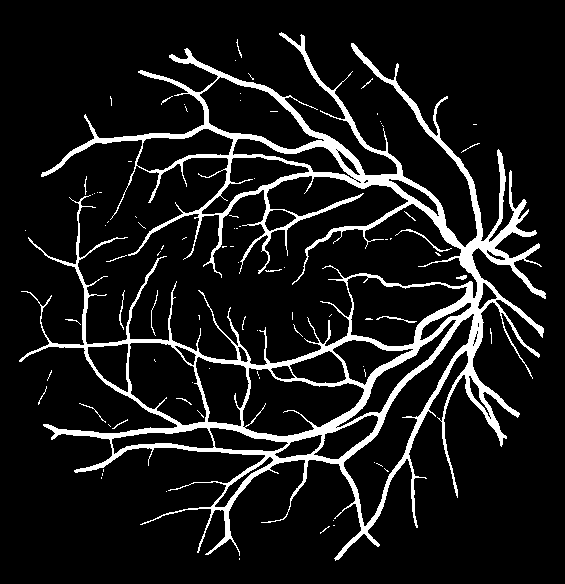

In [21]:
Image.fromarray(placeholder)

In [22]:
truth = binarize(truth.mean(0))
truth = truth[meta.step_sz:-meta.step_sz, meta.step_sz:-meta.step_sz]
truth = truth[:fov.shape[0], :fov.shape[1]]
truth *= fov
truth *= 255.
truth = truth.astype(np.uint8)

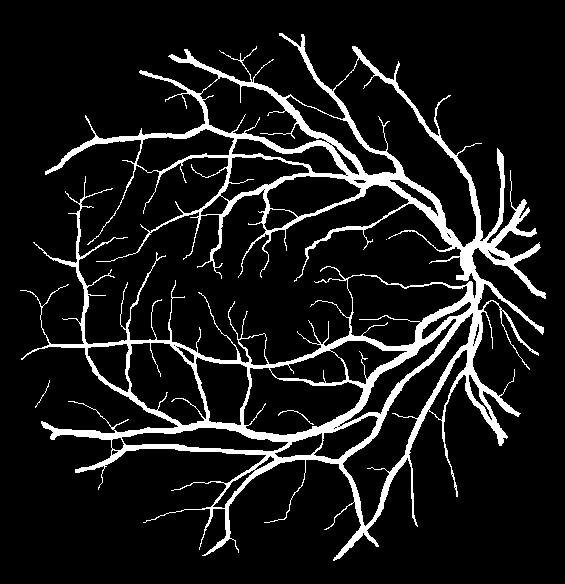

In [23]:
Image.fromarray(truth)

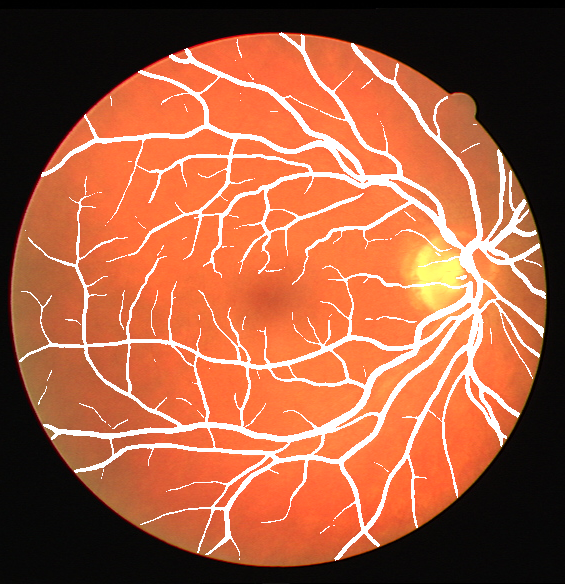

In [24]:
img = Image.open("../data/DRIVE/test/images/02_test.tif")
img = np.array(img)
img[placeholder>0, ...] = [255, 255, 255]

Image.fromarray(img)

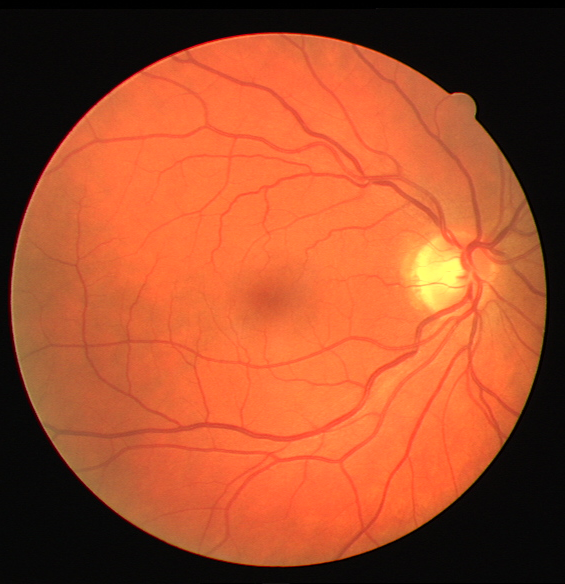

In [25]:
Image.open("../data/DRIVE/test/images/02_test.tif")

In [ ]:
for run_no, (name, cfg, meta) in enumerate(zip(DATASETS, CONFIGS, METAS)):
    # cleanup
    
    name, cfg, meta = DA
    
    del X_test, Y_test, dset_test, samp_test, collate_fn
    del test, model, bce, adam, vis
    del step, loss_win, epoc_win, f, i, images, masks
    del preds, loss, acc, auc

    gc.collect()        
    time.sleep(30)
    gc.collect()
        
    # load
    
    X_test = th.from_numpy(np.load(os.path.join(FINAL, f"{name}", "test_X.npy")))
    Y_test = th.from_numpy(np.load(os.path.join(FINAL, f"{name}", "test_Y.npy")))
    Y_pred = th.FloatTensor(*Y_test.size()).zero_()
    
    dset_test = th.utils.data.TensorDataset(X_test, Y_test)
    samp_test = th.utils.data.sampler.SequentialSampler(dset_test)
    collate_fn = make_collate(divide_masks=True)

    test = th.utils.data.DataLoader(dset_test, batch_size=32, 
                                     sampler=samp_test, num_workers=6, 
                                     collate_fn=collate_fn, pin_memory=True)
    
    prepare
                            
    model = UNet(cfg)
    model.load_state_dict(th.load(f"../data-ssd/model-{run_no}-{name}.th"))
    model = model.cuda()

    model.train(False)
    idx = 0
    for images, masks in tqdm(test):
        images = Var(images.cuda(async=True), volatile=True)
        masks  = Var(masks.cuda(async=True), volatile=True)

        preds = model(images).squeeze()

        n = preds.size(0)
        Y_pred[idx:idx+n, ...] = preds.data.cpu()
        idx += n
        